In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import set_config
set_config(display='diagram')

## Khám phá dữ liệu

In [2]:
df = pd.read_csv('phones_preprocessed.csv')
df.head()

,brand,technology,display_colors,screen_size,screen_area,screen_to_body_ratio,screen_resolution,rear_camera,front_camera,os,...,radio,headphone_jack,length,width,high,battery_mah,battery_removable,battery_type,real_price,_4G
0,A1,IPS LCD,16.0,6.26,97.8,82.1,1094400.0,13.0,8.0,Android 9.0,...,1.0,1.0,151.7,75.8,8.1,3200,0.0,Li-Ion,1.0,1.0
1,A1,IPS LCD,16.0,5.50,78.1,77.1,1036800.0,13.0,8.0,Android 8.1,...,1.0,1.0,147.1,68.8,8.7,2900,0.0,Li-Ion,0.0,1.0
2,Acer,IPS LCD,16.0,5.00,68.9,65.3,921600.0,8.0,2.0,Android 6.0,...,1.0,1.0,145.5,72.5,8.5,2000,1.0,Li-Ion,0.0,1.0
3,Acer,IPS LCD,16.0,5.50,83.4,71.7,2073600.0,13.0,5.0,Android 6.0,...,1.0,1.0,153.8,75.6,8.5,4080,0.0,Li-Po,1.0,1.0
4,Acer,IPS LCD,16.0,5.00,68.9,66.4,921600.0,8.0,5.0,Android 6.0,...,1.0,1.0,145.7,71.2,8.4,2000,1.0,Li-Ion,0.0,1.0


### Dữ liệu có bao nhiêu dòng, bao nhiêu cột

In [3]:
df.shape

(4198, 24)

### Xem xét cột output

In [4]:
# Cột output hiện có kiểu dữ liệu gì?
df.real_price.dtype

dtype('float64')

In [5]:
# Cột output có giá trị thiếu không?
df.real_price.isna().sum()

0

In [6]:
# Tỉ lệ các lớp trong cột output?
df.real_price.value_counts(normalize=True) * 100

1.0    41.519771
0.0    38.232492
2.0    20.247737
Name: real_price, dtype: float64

### Mỗi cột hiện đang có kiểu dữ liệu gì?

In [7]:
df.dtypes

brand                    object
technology               object
display_colors          float64
screen_size             float64
screen_area             float64
screen_to_body_ratio    float64
screen_resolution       float64
rear_camera             float64
front_camera            float64
os                       object
external_memory         float64
internal_memory         float64
cpu                     float64
weight                  float64
radio                   float64
headphone_jack          float64
length                  float64
width                   float64
high                    float64
battery_mah               int64
battery_removable       float64
battery_type             object
real_price              float64
_4G                     float64
dtype: object

### Với mỗi cột input có kiểu dữ liệu dạng số, các giá trị được phân bố như thế nào?

In [8]:
num_col_info_df = df.select_dtypes(exclude='object')
def missing_ratio(s):
    return (s.isna().mean() * 100).round(1)
def median(num_col_info_df):
    return num_col_info_df.quantile(0.5).round(1)
def lower_quartile(num_col_info_df):
    return num_col_info_df.quantile(0.25).round(1)
def upper_quartile(num_col_info_df):
    return num_col_info_df.quantile(0.75).round(1)
num_col_info_df.agg([missing_ratio, min, lower_quartile, median, upper_quartile, max])

,display_colors,screen_size,screen_area,screen_to_body_ratio,screen_resolution,rear_camera,front_camera,external_memory,internal_memory,cpu,weight,radio,headphone_jack,length,width,high,battery_mah,battery_removable,real_price,_4G
missing_ratio,5.900,0.0,0.3,2.7,0.1,0.0,0.0,0.1,7.700000,3.200,7.5,3.0,0.1,2.5,2.5,2.6,0.0,0.0,0.0,0.0
min,0.065,0.0,9.3,16.4,36608.0,0.0,0.0,0.0,0.000977,0.123,71.0,0.0,0.0,67.0,43.4,0.0,0.0,0.0,0.0,0.0
lower_quartile,16.000,4.0,45.5,58.2,384000.0,5.0,0.3,1.0,0.800000,1.100,130.2,0.0,1.0,124.0,64.2,8.2,1540.0,0.0,0.0,0.0
median,16.000,5.0,68.9,67.5,921600.0,8.0,2.1,1.0,2.000000,1.400,150.3,1.0,1.0,143.4,71.1,9.1,2400.0,0.0,1.0,1.0
upper_quartile,16.000,5.7,85.1,74.5,2073600.0,13.0,8.0,1.0,4.000000,2.000,173.0,1.0,1.0,154.7,75.2,11.0,3300.0,1.0,1.0,1.0
max,1000.000,203.0,205.0,180.8,8294400.0,108.0,108.0,1.0,12.000000,3.130,469.0,1.0,1.0,194.3,145.2,28.2,30000.0,1.0,2.0,1.0


### Với mỗi cột input có kiểu dữ liệu không phải dạng số, các giá trị được phân bố như thế nào?

In [9]:
pd.set_option('display.max_colwidth', 200) # Để nhìn rõ hơn
cat_cols = list(set(df.columns) - set(num_col_info_df))
df1 = df[cat_cols]
def missing_ratio(df1):
    return (df1.isna().mean() * 100).round(1)
def num_values(df1):
    return df1.nunique()
def value_ratios(c):
    return dict((c.value_counts(normalize=True) * 100).round(1))
df1.agg([missing_ratio, num_values, value_ratios])

,technology,brand,os,battery_type
missing_ratio,3.7,0,2.6,2.2
num_values,80,83,144,2
value_ratios,"{'IPS LCD': 43.8, 'TFT': 27.4, 'Super AMOLED': 8.4, 'AMOLED': 5.9, 'LTPS IPS LCD': 2.8, 'OLED': 1.4, 'S-LCD': 0.6, 'PLS TFT': 0.6, 'LED-backlit LCD': 0.6, 'LED-backlit IPS LCD': 0.6, 'Super LCD3':...","{'Samsung': 10.4, 'Huawei': 7.0, 'Lg': 5.6, 'Htc': 5.4, 'Motorola': 5.1, 'Nokia': 4.6, 'Oppo': 4.5, 'Zte': 3.6, 'Vivo': 3.5, 'Micromax': 3.5, 'Lenovo': 3.3, 'Xiaomi': 3.1, 'Alcatel': 3.0, 'Blu': 2...","{'Android 9.0': 8.1, 'Android 4.4.2': 7.3, 'Android 10': 6.8, 'Android 8.1': 4.7, 'Android 4.2': 4.5, 'Android 5.1': 4.3, 'Android 6.0': 4.2, 'Android 2.3': 3.6, 'Android 7.0': 3.4, 'Android 4.0':...","{'Li-Ion': 67.7, 'Li-Po': 32.3}"


## Đặt câu hỏi

- Câu hỏi: Dự đoán khoảng giá (thấp, trung bình, cao) của điện thoại dựa trên các thuộc tính đặc trưng của điện thoại?
    - Input: Các đặc trưng của điện thoại
    - Output: Khoảng giá của điện thoại
- Ý nghĩa thực tế:
    - Đối với người tiêu dùng: Đem lại các thông tin cần thiết cho người muốn mua điện thoại (ví dụ: khi người tiêu dùng muốn mua điện thoại có cấu hình nào đó thì mức giá sẽ rơi vào khoảng bao nhiêu)
    - Đối với nhà sản xuất: Cân nhắc để đưa ra được mức giá phù hợp cho điện thoại chuẩn bị tung ra thị trường

## Tách tập và xem xét độ tương quan giữa các thuộc tính

### Tách tập (train, test)

In [10]:
y = df.real_price
X = df.drop('real_price', axis = 1)

In [11]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=0)

In [12]:
train_data = train_X.copy()
train_data['real_price'] = train_y.copy()

In [13]:
train_data.to_csv('train_data.csv', index = False)
test_X.to_csv('test_X.csv', index = False)
test_y.to_csv('test_y.csv', index = False)

In [14]:
train_df = pd.read_csv('train_data.csv')

In [15]:
train_df.shape

(3358, 24)

### Xem xét độ tương quan giữa các thuộc tính
- Copy tập train ra và xử lý các giá trị nan trên đó, sau đó vẽ biểu đồ Heatmap để xem xét độ tương quan

In [16]:
df = train_df.copy()

In [17]:
num_mean_cols = ['display_colors', 'screen_size', 'screen_area', 'screen_to_body_ratio', 'screen_resolution', 'rear_camera',
            'front_camera', 'internal_memory', 'cpu', 'weight', 'length', 'width', 'high', 'battery_mah']


In [18]:

num_median_cols = ['external_memory', 'radio', 'headphone_jack', 'battery_removable', '_4G' ]

In [19]:
for col in num_mean_cols:
    df[col] = df[col].apply(lambda x: df[col].mean() if str(x) == 'nan' else x)

In [20]:
for col in num_median_cols:
    df[col] = df[col].apply(lambda x: df[col].median() if str(x) == 'nan' else x)

#### Vẽ biểu đồ Heatmap biểu diễn sự tương quan của các thuộc tính

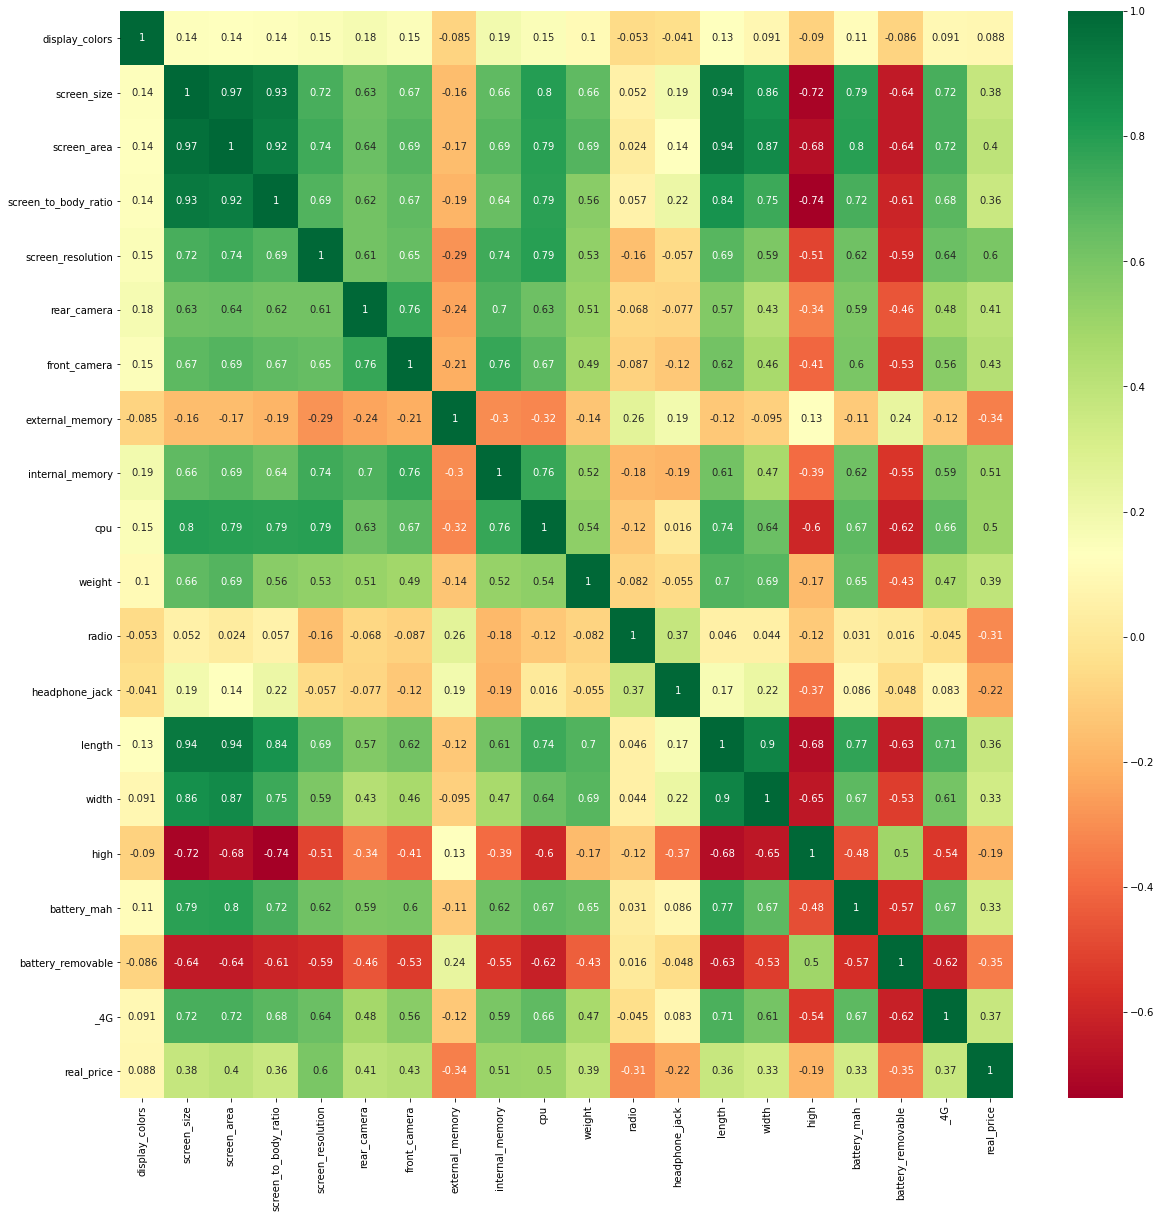

In [21]:
X = df.iloc[:,0:]  
y = df.real_price  
corrmat = df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
g=sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

### Tách tập (train, validation)
- Từ tập train đã tách ở trên tiếp tục tách ra thành 2 tập train và validation

In [22]:
y = train_df.real_price
X = train_df.drop('real_price', axis = 1)

In [23]:
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.2, random_state=0)

In [24]:
train_X.shape


(2686, 23)

In [25]:
val_X.shape


(672, 23)

In [26]:
train_y.shape


(2686,)

In [27]:

val_y.shape

(672,)

## Tiền xử lý và chạy mô hình

### Tiền xử lý (tập huấn luyện)
- Sau khi xem xét độ tương quan giữa các thuộc tính, ta bỏ thêm một số cột nữa vì độ tương quan với thuộc tính lớp là không cao: `high`, `display_colors`, `headphone_jack`, `radio`
- Class `ColAdderDropper` để thực hiện xóa các cột ở trên và tính toán `num_top_titles` của các thuộc tính `brand`, `technology`, `os`

In [28]:
class ColAdderDropper(BaseEstimator, TransformerMixin):
    def __init__(self, num_top_titles=10, col_name = 'brand'):
        self.num_top_titles = num_top_titles
        self.col_name = col_name
    def fit(self, X_df, y=None):
        a = self.col_name
        title_col = X_df[a].str.extract(r'([a-zA-z ]+)', expand=False)
        self.title_counts_ = title_col.value_counts()
        titles = list(self.title_counts_.index)
        self.top_titles_ = titles[:max(1, min(self.num_top_titles, len(titles)))]
        return self
    def transform(self, X_df, y=None):
        transform_df = X_df.copy()
        a = self.col_name
        title_col = transform_df[a].str.extract(r'([a-zA-z ]+)', expand=False)
        title_col[~title_col.isin(self.top_titles_)] = 'Others'
        transform_df[a] = title_col
        if (self.col_name == 'brand'):
            transform_df.drop(['high', 'display_colors', 'headphone_jack', 'radio'], axis = 1, inplace = True)
        return transform_df
    

### Tạo pipeline để thực hiện tiền xử lý
- Đối với các cột dạng số, sẽ điền giá trị thiếu bằng giá trị mean của cột
- Đối với các cột dạng số nhưng có dạng (0,1), sẽ điền giá trị thiếu bằng giá trị median của cột
- Đối với các cột không phải dạng số:
    - Điền giá trị thiếu bằng giá trị mode (giá trị xuất hiện nhiều nhất) của cột
    - Sau đó, sẽ chuyển sang dạng số bằng phương pháp mã hóa one - hot

In [29]:
num_mean_cols = ['screen_size', 'screen_area', 'screen_to_body_ratio', 'screen_resolution', 'rear_camera',
            'front_camera', 'internal_memory', 'cpu', 'weight', 'length', 'width', 'battery_mah']
num_median_cols = ['external_memory', 'battery_removable', '_4G']
unorder_cate_cols = ['brand', 'technology', 'os', 'battery_type']
imp_mean = SimpleImputer(strategy='mean')
imp_median = SimpleImputer(strategy='median')
imp_mode = SimpleImputer(strategy = 'most_frequent')

enc = OneHotEncoder(handle_unknown='ignore')
col_brand = ColAdderDropper(col_name = 'brand')
col_technology = ColAdderDropper(col_name = 'technology')
col_os = ColAdderDropper(col_name = 'os')
unorder_cate_transformer = make_pipeline(imp_mode, enc)

column_trans = ColumnTransformer(transformers = [('num_mean', imp_mean, num_mean_cols),
                                                 ('num_median', imp_median, num_median_cols),
                                                 ('categorical', unorder_cate_transformer, 
                                                  unorder_cate_cols)], remainder = 'passthrough')
preprocess_pipeline = make_pipeline(col_brand, col_technology, col_os, column_trans, StandardScaler())
preprocess_pipeline

Pipeline(steps=[('coladderdropper-1', ColAdderDropper()),
                ('coladderdropper-2', ColAdderDropper(col_name='technology')),
                ('coladderdropper-3', ColAdderDropper(col_name='os')),
                ('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_mean', SimpleImputer(),
                                                  ['screen_size', 'screen_area',
                                                   'screen_to_body_ratio',
                                                   'screen_resolution',
                                                   're...
                                                   'weight', 'length', 'width',
                                                   'battery_mah']),
                                                 ('num_median',
                                                  SimpleImputer(strategy='median'),
                                                  ['external_memory',
                                                   'battery_removable',
                                                   '_4G']),
                                                 ('categorical',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['brand', 'technology', 'os',
                                                   'battery_type'])])),
                ('standardscaler', StandardScaler())])

### Tiền xử lý + Mô hình hóa

#### Mô hình Random Forest
- Tạo `full_pipeline` gồm các bước tiền xử lý ở trên + Random Forest (với các siêu tham số `n_estimators = 1, random_state = 0, verbose = 1, max_features = 0.3, min_samples_leaf = 3, max_depth = 10`)
- Thử nghiệm mô hình với các siêu tham số: 
    - `n_estimators` với các giá trị từ 1, 6, 11,..., 100
    - `num_top_titles` với 6 giá trị: 1, 3, 5, 7, 9, 11

In [30]:
rfregressor = RandomForestClassifier(n_estimators=1, random_state=0, verbose=1, max_features = 0.3, min_samples_leaf = 3, max_depth = 10)
full_pipeline = Pipeline([('brand',col_brand),('technology', col_technology),('os' ,col_os),('trans', column_trans),('standard', StandardScaler()),('rfr', rfregressor)])

full_pipeline.set_params(rfr__verbose = 0)
rf_train_scores, rf_val_scores = [], []
num_top_titles_s = [1, 3, 5, 7, 9, 11]
best_n_estimators, best_val_score = 1, -float('inf')
best_num_top_titles_rfc = None
n_estimators = 1
while (n_estimators < 100):
    for num_top_titles in num_top_titles_s:
        print('n_estimators: ',n_estimators)
        full_pipeline.set_params(brand__num_top_titles = num_top_titles, technology__num_top_titles= num_top_titles, os__num_top_titles = num_top_titles, rfr__n_estimators = n_estimators)
        full_pipeline.fit(train_X, train_y)
        train_score = full_pipeline.score(train_X, train_y)
        val_score = full_pipeline.score(val_X, val_y)
        print(train_score, val_score)
        rf_train_scores.append(train_score)
        rf_val_scores.append(val_score)
        if best_val_score < val_score:
            best_val_score, best_n_estimators = val_score, n_estimators
            best_num_top_titles_rfc = num_top_titles
    n_estimators += 5
    print()

n_estimators:  1
0.7148175725986597 0.5773809523809523
n_estimators:  1
0.7125837676842889 0.5952380952380952
n_estimators:  1
0.7137006701414743 0.6071428571428571
n_estimators:  1
0.7062546537602383 0.625
n_estimators:  1
0.7211466865227103 0.6101190476190477
n_estimators:  1
0.7244973938942666 0.6547619047619048

n_estimators:  6
0.8306031273268801 0.6607142857142857
n_estimators:  6
0.8153387937453462 0.6681547619047619
n_estimators:  6
0.8287416232315711 0.6458333333333334
n_estimators:  6
0.8198064035740878 0.6711309523809523
n_estimators:  6
0.8343261355174981 0.6681547619047619
n_estimators:  6
0.8112434847356664 0.6770833333333334

n_estimators:  11
0.840282948622487 0.65625
n_estimators:  11
0.840282948622487 0.6666666666666666
n_estimators:  11
0.8387937453462397 0.6770833333333334
n_estimators:  11
0.8391660461653015 0.6755952380952381
n_estimators:  11
0.8484735666418466 0.6815476190476191
n_estimators:  11
0.8346984363365599 0.6934523809523809

n_estimators:  16
0.8384214

In [31]:
best_n_estimators

26

In [32]:

best_num_top_titles_rfc

11

In [33]:

best_val_score

0.7142857142857143

#### Mô hình SVC
- Tạo `full_pipeline` gồm các bước tiền xử lý ở trên + SVC (với các siêu tham số `C = 1, random_state = 1, probability = True, decision_function_shape = ovo`)
- Thử nghiệm mô hình với các siêu tham số: 
    - `num_top_titles` với 6 giá trị: 1, 3, 5, 7, 9, 11

In [34]:

svc = SVC(kernel='linear', C=1, random_state = 1 , probability= True, decision_function_shape = 'ovo')

full_pipeline = Pipeline([('brand',col_brand),('technology', col_technology),('os' ,col_os),('trans', column_trans),('standard', StandardScaler()),('svc',svc)])

svc_train_scores, svc_val_scores = [], []
num_top_titles_s = [1,3,5,7,9,11]
best_val_score = -float('inf')
best_num_top_titles_svc = None


for num_top_titles in num_top_titles_s:
    print(num_top_titles)
    full_pipeline.set_params(brand__num_top_titles = num_top_titles, technology__num_top_titles= num_top_titles, os__num_top_titles = num_top_titles)
    full_pipeline.fit(train_X, train_y)
    train_score = full_pipeline.score(train_X, train_y)
    val_score = full_pipeline.score(val_X, val_y)
    print(train_score, val_score)
    svc_train_scores.append(train_score)
    svc_val_scores.append(val_score)
    if best_val_score < val_score:
        best_val_score = val_score
        best_num_top_titles_svc = num_top_titles
    print()

1
0.637379002233805 0.6056547619047619

3
0.6556217423678332 0.6235119047619048

5
0.676842889054356 0.6502976190476191

7
0.6809381980640358 0.6532738095238095

9
0.6787043931496649 0.6473214285714286

11
0.684288905435592 0.6398809523809523



In [35]:
best_val_score

0.6532738095238095

In [36]:
best_num_top_titles_svc

7

#### Mô hình Neural Network
- Tạo `full_pipeline` gồm các bước tiền xử lý ở trên + Neural Network (với các siêu tham số `hidden_layer_sizes = (128) hoặc = (256, 128), solver = adam, learning_rate = adaptive, random_state = 0, max_iter = 500, early_stopping = True, verbose = 0`)
- Thử nghiệm mô hình với các siêu tham số: 
    - `alpha` với 5 giá trị: 0.1, 1, 10, 100, 1000
    - `num_top_titles` với 6 giá trị: 1, 3, 5, 7, 9, 11

In [37]:
mlpclassifier = MLPClassifier(hidden_layer_sizes=(128), solver='adam', learning_rate='adaptive'\
                            ,random_state=0, max_iter=500, early_stopping=True, verbose=0)
full_pipeline = Pipeline([('brand',col_brand),('technology', col_technology),('os' ,col_os),('trans', column_trans),('standard', StandardScaler()),('mlp', mlpclassifier)])

mlp_train_scores = []
mlp_val_scores = []
alphas = [0.1, 1, 10, 100, 1000]
num_top_titles_s = [1, 3, 5, 7, 9, 11]
best_val_score = -float('inf'); best_alpha = None; best_num_top_titles_mlp1 = None
for alpha in alphas:
    for num_top_titles in num_top_titles_s:
        full_pipeline.set_params(brand__num_top_titles = num_top_titles, technology__num_top_titles= num_top_titles, os__num_top_titles = num_top_titles, mlp__alpha = alpha)
        full_pipeline.fit(train_X, train_y)
        train_score = full_pipeline.score(train_X, train_y)
        val_score = full_pipeline.score(val_X, val_y)
        print(train_score, val_score)
        mlp_train_scores.append(train_score)
        mlp_val_scores.append(val_score)
        if (best_val_score < val_score):
            best_val_score = val_score
            best_alpha = alpha
            best_num_top_titles_mlp1 = num_top_titles
        print()

0.6827997021593447 0.6294642857142857

0.6895011169024572 0.6383928571428571

0.6969471332836932 0.65625

0.6891288160833954 0.6666666666666666

0.7096053611317945 0.6651785714285714

0.7356664184661206 0.6651785714285714

0.6757259865971705 0.6130952380952381

0.6567386448250186 0.6264880952380952

0.6865227103499628 0.6636904761904762

0.6827997021593447 0.6607142857142857

0.7073715562174236 0.6651785714285714

0.6932241250930752 0.6547619047619048

0.6154132539091586 0.5922619047619048

0.616530156366344 0.6101190476190477

0.6392405063291139 0.6235119047619048

0.6355174981384959 0.6160714285714286

0.6574832464631423 0.6264880952380952

0.6254653760238272 0.6071428571428571

0.5666418466120625 0.5580357142857143

0.5454206999255399 0.5610119047619048

0.5428145941921072 0.5386904761904762

0.5595681310498883 0.5223214285714286

0.5930752047654505 0.5863095238095238

0.5551005212211467 0.5386904761904762

0.4973938942665674 0.5029761904761905

0.46649292628443784 0.491071428571428

In [38]:
best_val_score

0.6666666666666666

In [39]:
best_num_top_titles_mlp1

7

In [40]:
mlpclassifier = MLPClassifier(hidden_layer_sizes=(256, 128), solver='adam', learning_rate='adaptive'\
                            ,random_state=0, max_iter=500, early_stopping=True, verbose=0)
full_pipeline = Pipeline([('brand',col_brand),('technology', col_technology),('os' ,col_os),('trans', column_trans),('standard', StandardScaler()),('mlp', mlpclassifier)])

mlp_train_scores = []
mlp_val_scores = []
alphas = [0.1, 1, 10, 100, 1000]
num_top_titles_s = [1, 3, 5, 7, 9, 11]
best_val_score = -float('inf'); best_alpha = None; best_num_top_titles_mlp2 = None
for alpha in alphas:
    for num_top_titles in num_top_titles_s:
        full_pipeline.set_params(brand__num_top_titles = num_top_titles, technology__num_top_titles= num_top_titles, os__num_top_titles = num_top_titles, mlp__alpha = alpha)
        full_pipeline.fit(train_X, train_y)
        train_score = full_pipeline.score(train_X, train_y)
        val_score = full_pipeline.score(val_X, val_y)
        print(train_score, val_score)
        mlp_train_scores.append(train_score)
        mlp_val_scores.append(val_score)
        if (best_val_score < val_score):
            best_val_score = val_score
            best_alpha = alpha
            best_num_top_titles_mlp2 = num_top_titles
        print()

0.695457930007446 0.6101190476190477

0.7419955323901712 0.6502976190476191

0.7851824274013403 0.6547619047619048

0.7129560685033507 0.6651785714285714

0.7338049143708116 0.6696428571428571

0.7822040208488459 0.6681547619047619

0.695457930007446 0.6473214285714286

0.6947133283693224 0.6443452380952381

0.7401340282948623 0.6681547619047619

0.723752792256143 0.6577380952380952

0.7308265078183172 0.6607142857142857

0.7386448250186151 0.6696428571428571

0.6102010424422933 0.5952380952380952

0.6183916604616531 0.5997023809523809

0.6448250186150409 0.6294642857142857

0.6448250186150409 0.6235119047619048

0.6396128071481757 0.6086309523809523

0.6530156366344005 0.6339285714285714

0.539463886820551 0.5282738095238095

0.5722263588979896 0.5446428571428571

0.5271779597915115 0.5357142857142857

0.5245718540580789 0.5148809523809523

0.5256887565152644 0.49851190476190477

0.54132539091586 0.5238095238095238

0.5223380491437081 0.5

0.4441548771407297 0.4181547619047619

0.4180

In [41]:
best_val_score

0.6696428571428571

In [42]:
best_num_top_titles_mlp2

9

#### Lấy mô hình tốt nhất để train cho toàn tập train + validation

In [43]:
rfregressor = RandomForestClassifier(n_estimators=1, random_state=0, verbose=1, max_features = 0.3, min_samples_leaf = 3, max_depth = 10)
full_pipeline = Pipeline([('brand',col_brand),('technology', col_technology),('os' ,col_os),('trans', column_trans),('standard', StandardScaler()),('rfr', rfregressor)])

In [44]:
best_num_top_titles = 11
full_pipeline.set_params(brand__num_top_titles = best_num_top_titles_rfc, technology__num_top_titles= best_num_top_titles_rfc, os__num_top_titles = best_num_top_titles_rfc, rfr__n_estimators = best_n_estimators)
full_pipeline.fit(X, y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed:    0.1s finished


Pipeline(steps=[('brand', ColAdderDropper(num_top_titles=11)),
                ('technology',
                 ColAdderDropper(col_name='technology', num_top_titles=11)),
                ('os', ColAdderDropper(col_name='os', num_top_titles=11)),
                ('trans',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_mean', SimpleImputer(),
                                                  ['screen_size', 'screen_area',
                                                   'screen_to_body_ratio',
                                                   'screen_resoluti...
                                                   '_4G']),
                                                 ('categorical',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['brand', 'technology', 'os',
                                                   'battery_type'])])),
                ('standard', StandardScaler()),
                ('rfr',
                 RandomForestClassifier(max_depth=10, max_features=0.3,
                                        min_samples_leaf=3, n_estimators=26,
                                        random_state=0, verbose=1))])

## Đánh giá mô hình tìm được

In [45]:
test_X = pd.read_csv('test_X.csv')
test_y = pd.read_csv('test_y.csv')

In [46]:
full_pipeline.score(test_X, test_y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed:    0.0s finished


0.7416666666666667